In [1]:
import os
import numpy as np
import numpy.random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure as meas, feature as feat
import cv2 as cv
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
traindir = 'D:/Kenneth/Documents/VIP/Datasets/fruits-360/Training/'
class1dir = traindir + 'Banana/'
class2dir = traindir + 'Apple Red 1/'
class3dir = traindir + 'Orange/'

In [4]:
ban_a, app_a, ora_a = np.load('astar-ban_app_ora.npy')
ban_b, app_b, ora_b = np.load('bstar-ban_app_ora.npy')
ban_e, app_e, ora_e = np.load('ecc-ban_app_ora.npy')

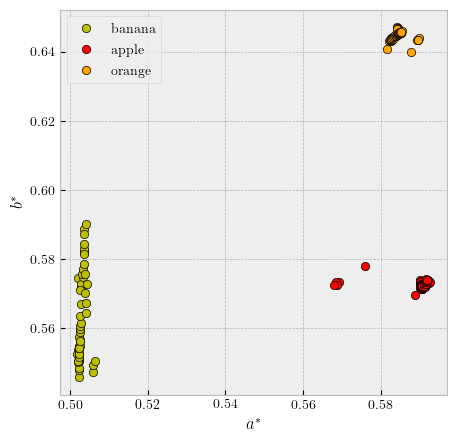

In [119]:
plt.plot(ban_a, ban_b, 'yo', mec='k', mew=0.5)
plt.plot(app_a, app_b, 'ro', mec='k', mew=0.5)
plt.plot(ora_a, ora_b, 'o', color='orange', mec='k', mew=0.5)
plt.legend(['banana', 'apple', 'orange'])
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
# plt.savefig('ab-space.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
class MCPerceptron:
    def __init__(self,
                 input_shape, 
                 output_shape,
                 epochs,
                 activation='step',
                 lr=0.01,
                 eps=1e-6,
                 weight_initializer='random_uniform'):
        rand.seed(401)
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.epochs = epochs
        self.activation = activation
        self.lr = lr
        self.eps = eps
        self.weight_initializer = weight_initializer
        
        if self.weight_initializer == 'random_uniform':
            self.W = rand.random(self.input_shape[1])
        elif self.weight_initializer == 'random_normal':
            self.W = rand.normal((0, 1, (self.input_shape[1])))

        if self.activation == 'step':
            self.g = lambda a: 1 if a >= 0 else -1

    def train(self, x, y):
        for count in tnrange(self.epochs, desc='Epoch'):
            for i in range(self.input_shape[0]):
                a = x[i].T.dot(self.W)
                z = self.g(a)

                res = y[i] - z
                dW = self.lr * res * x[i]
                self.W += dW
                
    def predict(self, x):
        y = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            f = x[i].dot(self.W)
            y[i] = self.g(f)
        return y
                
    def get_weights(self):
        return self.W
    
    def get_biases(self):
        return self.x.T[0]

    def get_line_params(self):
        W = self.W
        A, B, C = W[1], W[2], -W[0]
        m = -A/B
        b = C/B
        return m, b
    
    def save_weights(self, filename):
        np.save(filename, self.W)
        
    def load_weights(self, filename):
        self.W = np.load(filename)

In [109]:
x1 = np.hstack(([ban_a, ban_b], [app_a, app_b])).T
x1 = np.column_stack((np.ones(x1.shape[0]), x1))
y = np.hstack((np.tile([1], 50), np.tile([-1], 50))).T

In [110]:
mcp = MCPerceptron(x1.shape, y.shape, epochs=100, lr=1e-1)
mcp.train(x1, y)
W = mcp.get_weights()

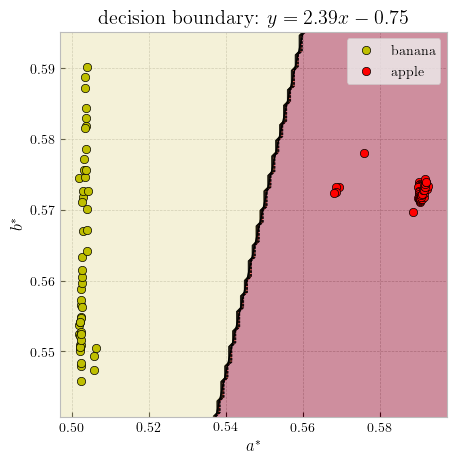

In [120]:
xmin, xmax = np.min((ban_a, app_a))-5e-3, np.max((ban_a, app_a))+5e-3
ymin, ymax = np.min((ban_b, app_b))-5e-3, np.max((ban_b, app_b))+5e-3
db_x = np.linspace(xmin, xmax, 100)
db_y = np.linspace(ymin, ymax, 100)
xx, yy = np.meshgrid(db_x, db_y)
Z = mcp.predict(np.c_[np.ones_like(xx.ravel()), xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap='YlOrRd_r', alpha=0.4)
plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
plt.plot(ban_a, ban_b, 'yo', mec='k', mew=0.5, label='banana')
plt.plot(app_a, app_b, 'ro', mec='k', mew=0.5, label='apple')
plt.plot(db_x, m*db_x+b, 'k-', lw=1)

decision_boundary = mcp.get_line_params()
decision_title = 'decision boundary: $y = %.2fx + %.2f$' if decision_boundary[1] >= 0 \
                 else 'decision boundary: $y = %.2fx - %.2f$'
plt.title(decision_title %tuple(np.abs(decision_boundary)))
plt.legend()
plt.xlabel('$a^*$')
plt.ylabel('$b^*$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.savefig('ban-app_decision.png', dpi=300, bbox_inches='tight')
plt.show()